# CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
# Define dual convolutional neural networks
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=4, stride=2)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 2)
        self.attention = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.max_pool(x)  # Add maximum pooling
        x = torch.relu(self.conv2(x))
        x = self.max_pool(x)  # Add maximum pooling again
         # Calculate attention weights
        attention_weights = torch.softmax(self.attention(x.mean(dim=(2, 3))), dim=1)
        # Weighted average features using attention weights
        x = (x * attention_weights.unsqueeze(2).unsqueeze(3)).sum(dim=(2, 3))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class EnsembleCNN(nn.Module):
    def __init__(self, num_networks=2):
        super(EnsembleCNN, self).__init__()
        self.num_networks = num_networks
        self.networks = nn.ModuleList([CNNWithAttention() for _ in range(num_networks)])

    def forward(self, x):
        predictions = torch.zeros(x.size(0), 2).to(x.device)  # Initialize prediction results
        for i in range(self.num_networks):
            predictions += self.networks[i](x)  # Accumulate predictions for each network
        predictions /= self.num_networks  # Averaged to get the final prediction
        return predictions
    
# Load data sets
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Assume that the dataset is stored in the data_dir directory, containing two subfolders malignant and benign, which hold images of malignant and benign tumors, respectively
train_dir = "archive/test"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dir = "archive/train"
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Delineate training and test sets

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create data loaders
model = EnsembleCNN(num_networks=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
best_model_state_dict = model.state_dict()
best_accuracy = 0.0

# Training models
train_losses = []
test_losses = []
test_accuracies = []
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Record average training losses
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}")


    # Evaluate models on test sets
    model.eval()
    correct = 0
    total = 0

    total_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {avg_test_loss}")
        
        
# If the current model's accuracy is better than the previous highest accuracy, save the current model's state dictionary
if  accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model_state_dict = model.state_dict()

# Models that preserve optimal parameters
torch.save(best_model_state_dict, "best_model.pth")
print("Best model saved.")


Epoch 1/30, Train Loss: 1.4920310463224138
Test Accuracy: 68.94%, Test Loss: 0.6865353284471006
Epoch 2/30, Train Loss: 0.6435764304229191
Test Accuracy: 73.04%, Test Loss: 0.532040788825736
Epoch 3/30, Train Loss: 0.5178866755394709
Test Accuracy: 77.44%, Test Loss: 0.47087241116776524
Epoch 4/30, Train Loss: 0.47432125891957966
Test Accuracy: 79.48%, Test Loss: 0.4625432022723807
Epoch 5/30, Train Loss: 0.49925235907236737
Test Accuracy: 68.45%, Test Loss: 0.5750763186489243
Epoch 6/30, Train Loss: 0.4917727850732349
Test Accuracy: 78.61%, Test Loss: 0.4258933410228017
Epoch 7/30, Train Loss: 0.41982169378371464
Test Accuracy: 78.88%, Test Loss: 0.4188374557408942
Epoch 8/30, Train Loss: 0.4164496688615708
Test Accuracy: 74.71%, Test Loss: 0.4545791150934725
Epoch 9/30, Train Loss: 0.43523249172029044
Test Accuracy: 69.93%, Test Loss: 0.5546130507915135
Epoch 10/30, Train Loss: 0.4338634525026594
Test Accuracy: 77.40%, Test Loss: 0.4383006174880338
Epoch 11/30, Train Loss: 0.45012513

In [2]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.01%


In [3]:
torch.save(model,"83.01%_model.pth")

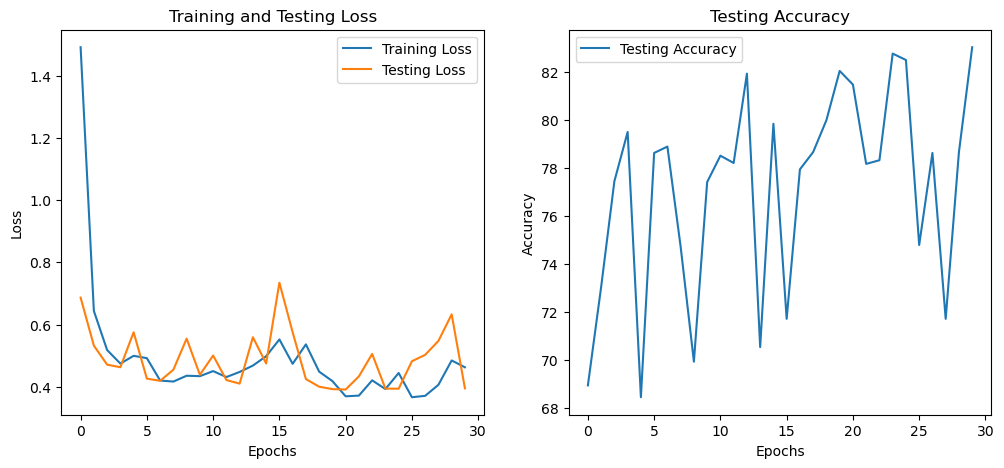

In [4]:
# Charting losses and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [5]:
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
       
        # Add projections and labels to the list
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate F1 score, precision and recall
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


F1 Score: 0.8301
Precision: 0.8356
Recall: 0.8365


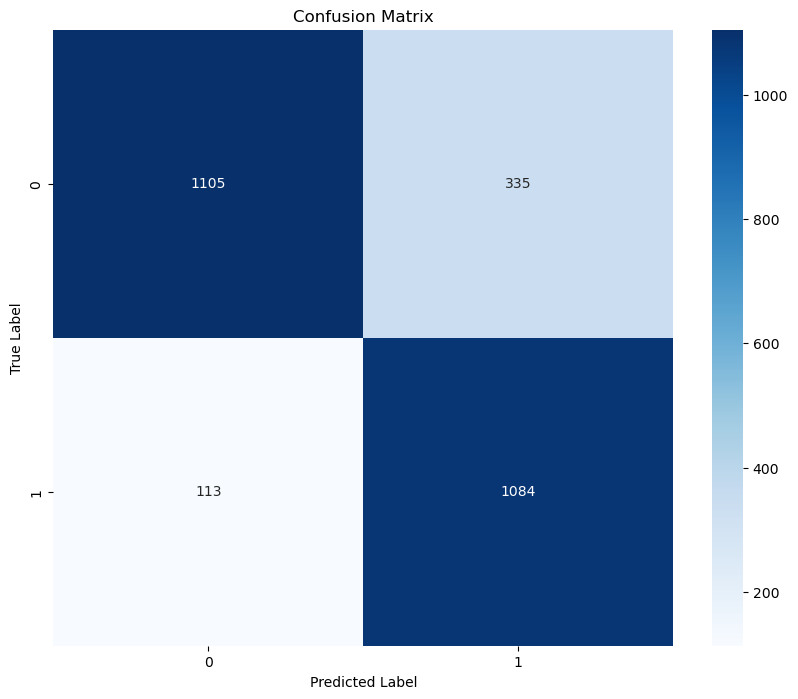

In [6]:
# Model evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

# Drawing the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


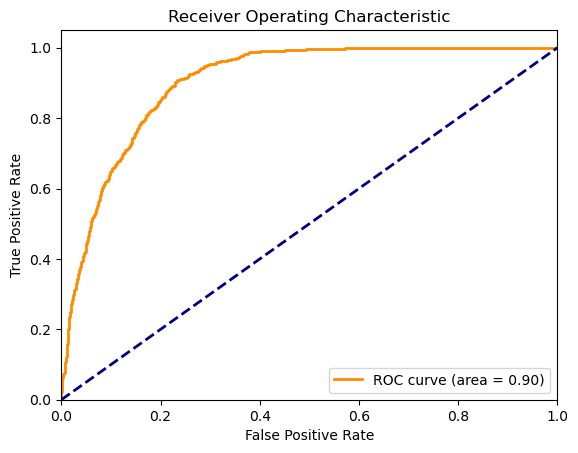

In [7]:
model.eval()
all_preds = []
all_labels = []
all_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        scores = outputs.softmax(dim=1)[:, 1]   # Get scores for positive categories (assuming label 1 is a positive category)

        all_scores.extend(scores.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plotting ROC curves
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# CRFC

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
# Define dual convolutional neural networks
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 2)
        self.attention = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.max_pool(x)  # Add maximum pooling
        x = torch.relu(self.conv2(x))
        x = self.max_pool(x)  # Add maximum pooling again
        # Calculate attention weights
        attention_weights = torch.softmax(self.attention(x.mean(dim=(2, 3))), dim=1)
         # Weighted average features using attention weights
        x = (x * attention_weights.unsqueeze(2).unsqueeze(3)).sum(dim=(2, 3))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
from sklearn.metrics import accuracy_score

class EnsembleCNNWithRandomForest(nn.Module):
    def __init__(self, num_networks=2):
        super(EnsembleCNNWithRandomForest, self).__init__()
        self.num_networks = num_networks
        self.networks = nn.ModuleList([CNNWithAttention() for _ in range(num_networks)])
        self.random_forest = RandomForestClassifier(n_estimators=100)  # Random forest model

    def forward(self, x):
        # Extract features for deep learning models
        features = []
        for i in range(self.num_networks):
            features.append(self.networks[i](x).detach().cpu().numpy())  # Use detach to disconnect the gradient stream and move to the CPU
        features = np.concatenate(features, axis=1)   # Splice the features into a matrix

        return torch.tensor(features).to(x.device)
# Load data sets
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Assume that the dataset is stored in the data_dir directory, containing two subfolders malignant and benign, which hold images of malignant and benign tumors, respectively
train_dir = "archive/test"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dir = "archive/train"
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Delineate training and test sets

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function and optimizer
model = EnsembleCNNWithRandomForest(num_networks=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model_state_dict = model.state_dict()
best_accuracy = 0.0
train_features = []
train_labels = []
for inputs, labels in train_loader:
    features = model(inputs)
    train_features.append(features)
    train_labels.append(labels)
train_features = torch.cat(train_features, dim=0).numpy()
train_labels = torch.cat(train_labels, dim=0).numpy()

# Train the random forest model
model.random_forest.fit(train_features, train_labels)

# Predictions on test sets
test_features = []
for inputs, _ in test_loader:
    features = model(inputs)
    test_features.append(features)
test_features = torch.cat(test_features, dim=0).numpy()

predicted_labels = model.random_forest.predict(test_features)

# Calculation accuracy
true_labels = torch.cat([labels for _, labels in test_loader], dim=0).numpy()
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Ensemble Model Test Accuracy: {accuracy * 100:.2f}%")

Ensemble Model Test Accuracy: 78.95%


# CNN+RFC

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from torchvision import transforms, datasets
# 定义卷积神经网络
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 2)
        self.attention = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.max_pool(x)  # Add maximum pooling
        x = torch.relu(self.conv2(x))
        x = self.max_pool(x) # Add maximum pooling again
         # Calculate attention weights
        attention_weights = torch.softmax(self.attention(x.mean(dim=(2, 3))), dim=1)
         # Weighted average features using attention weights
        x = (x * attention_weights.unsqueeze(2).unsqueeze(3)).sum(dim=(2, 3))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class EnsembleCNNWithRandomForest(nn.Module):
    def __init__(self, num_networks=2):
        super(EnsembleCNNWithRandomForest, self).__init__()
        self.num_networks = num_networks
        self.networks = nn.ModuleList([CNNWithAttention() for _ in range(num_networks)])
        self.random_forest = RandomForestClassifier(n_estimators=100)  # Random forest model

    def forward(self, x):
        # Extract features for deep learning models
        features = []
        for i in range(self.num_networks):
            features.append(self.networks[i](x))
        features = torch.cat(features, dim=1)   # Splicing features into a Tensor

        return features
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
# Load the dataset
# ...
# Assume that the dataset is stored in the data_dir directory, which contains two subfolders malignant and benign that hold images of malignant and benign tumors, respectively
train_dir = "archive/test"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dir = "archive/train"
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Delineate training and test sets

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Create EnsembleCNNWithRandomForest model
ensemble_model = EnsembleCNNWithRandomForest(num_networks=2)

# Training convolutional neural network models
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    ensemble_model.train()
    total_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Get deep learning model features as input
train_features = []
train_labels = []
for inputs, labels in train_loader:
    features = ensemble_model(inputs)
    train_features.append(features)
    train_labels.append(labels)
train_features = torch.cat(train_features, dim=0).detach().numpy()
train_labels = torch.cat(train_labels, dim=0).detach().numpy()

# Train the random forest model
ensemble_model.random_forest.fit(train_features, train_labels)

# Predictions on test sets
test_features = []
for inputs, _ in test_loader:
    features = ensemble_model(inputs)
    test_features.append(features)
test_features = torch.cat(test_features, dim=0).detach().numpy()

predicted_labels = ensemble_model.random_forest.predict(test_features)

# Calculation accuracy
true_labels = torch.cat([labels for _, labels in test_loader], dim=0).numpy()
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Ensemble Model Test Accuracy: {accuracy * 100:.2f}%")

Epoch [1/10], Loss: 6.2908
Epoch [2/10], Loss: 0.6683
Epoch [3/10], Loss: 0.4830
Epoch [4/10], Loss: 0.5070
Epoch [5/10], Loss: 0.4956
Epoch [6/10], Loss: 0.4517
Epoch [7/10], Loss: 0.6107
Epoch [8/10], Loss: 0.5263
Epoch [9/10], Loss: 0.4820
Epoch [10/10], Loss: 0.4334
Ensemble Model Test Accuracy: 76.26%
